# Automatic feature selection

The purpose of this notebook is to explore the possibility of a feature transformer that automatically selects the best combination of machine learning features from a list (i.e. AAC, PAAC, and the four PSSM-features). As a testing dataset, the four-substrate dataset from A. Thaliana is used.

In [14]:
import sys
from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    confusion_matrix,
    balanced_accuracy_score,
    f1_score,
)
from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV,
)
from sklearn.base import BaseEstimator, TransformerMixin

from subpred.transporter_dataset import create_dataset
from subpred.eval import full_test, get_independent_test_set, preprocess_pandas, optimize_hyperparams
from subpred.compositions import calculate_aac, calculate_paac
from subpred.pssm import calculate_pssms_notebook
from subpred.eval import preprocess_pandas


LOG_FILE = "../logs/athaliana_amino_sugar_potassium_feature_transformer.log"

## Dataset creation

In [15]:
sodium = ["Q2UVJ5", "O04034", "Q9FKP1", "Q9LJI2", "Q9SYG9", "Q84TI7"]
gdu = ["O81775", "Q9SW07", "Q9FHH5", "Q8S8A0", "Q3E965", "Q3EAV6", "Q3E8L0"]
df_all = create_dataset(
    keywords_substrate_filter=[
        "Amino-acid transport",
        "Electron transport",
        "Sugar transport",
        "Potassium transport",
    ],
    keywords_component_filter=["Transmembrane"],
    keywords_transport_filter=["Transport"],
    input_file="../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate="integrate",
    outliers=gdu + sodium,
    verbose=True,
    tax_ids_filter=[3702],
    output_log=LOG_FILE,
    sequence_clustering=70,
)

cd-hit: clustered 297 sequences into 223 clusters at threshold 70


In [16]:
labels = df_all.keywords_transport

In [17]:
df_aac = calculate_aac(df_all.sequence)
df_paac = calculate_paac(df_all.sequence)
df_pssm = calculate_pssms_notebook(df_all.sequence)

### Preparing the features:

Each feature type gets encoded in the column names of the feature dataframe, separated with a double-underscore from the feature name:

In [18]:
df_aac.columns = df_aac.columns.to_series().apply(lambda x: f"AAC__{x}")
df_aac.head()

,AAC__A,AAC__C,AAC__D,AAC__E,AAC__F,AAC__G,AAC__H,AAC__I,AAC__K,AAC__L,AAC__M,AAC__N,AAC__P,AAC__Q,AAC__R,AAC__S,AAC__T,AAC__V,AAC__W,AAC__Y
Uniprot,,,,,,,,,,,,,,,,,,,,
Q9SFG0,0.090730,0.015779,0.033531,0.035503,0.086785,0.088757,0.015779,0.092702,0.033531,0.104536,0.033531,0.033531,0.039448,0.029586,0.039448,0.055227,0.041420,0.086785,0.017751,0.025641
Q84WN3,0.066390,0.004149,0.020747,0.053942,0.070539,0.074689,0.008299,0.070539,0.041494,0.120332,0.029046,0.033195,0.041494,0.016598,0.029046,0.087137,0.058091,0.103734,0.016598,0.053942
P0DKI1,0.079812,0.004695,0.018779,0.028169,0.042254,0.065728,0.023474,0.065728,0.046948,0.098592,0.023474,0.032864,0.042254,0.046948,0.056338,0.122066,0.084507,0.061033,0.004695,0.051643
O04249,0.079922,0.013645,0.017544,0.042885,0.066277,0.107212,0.011696,0.076023,0.035088,0.120858,0.031189,0.038986,0.035088,0.035088,0.037037,0.064327,0.058480,0.081871,0.017544,0.029240
Q56ZZ7,0.128205,0.009158,0.020147,0.038462,0.051282,0.106227,0.003663,0.058608,0.031136,0.120879,0.020147,0.018315,0.027473,0.027473,0.040293,0.115385,0.051282,0.089744,0.014652,0.027473


In [19]:
df_paac.columns = df_paac.columns.to_series().apply(lambda x: f"PAAC__{x}")
df_paac.head()

,PAAC__AA,PAAC__AC,PAAC__AD,PAAC__AE,PAAC__AF,PAAC__AG,PAAC__AH,PAAC__AI,PAAC__AK,PAAC__AL,...,PAAC__YM,PAAC__YN,PAAC__YP,PAAC__YQ,PAAC__YR,PAAC__YS,PAAC__YT,PAAC__YV,PAAC__YW,PAAC__YY
Uniprot,,,,,,,,,,,,,,,,,,,,,
Q9SFG0,0.005929,0.001976,0.00000,0.000000,0.005929,0.005929,0.000000,0.003953,0.003953,0.009881,...,0.001976,0.0,0.000000,0.000000,0.001976,0.000000,0.0,0.003953,0.000000,0.000000
Q84WN3,0.004167,0.000000,0.00000,0.004167,0.004167,0.004167,0.000000,0.008333,0.004167,0.008333,...,0.004167,0.0,0.000000,0.000000,0.004167,0.000000,0.0,0.004167,0.000000,0.004167
P0DKI1,0.014151,0.000000,0.00000,0.000000,0.004717,0.009434,0.000000,0.014151,0.000000,0.014151,...,0.000000,0.0,0.004717,0.009434,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
O04249,0.005859,0.001953,0.00000,0.003906,0.009766,0.011719,0.001953,0.003906,0.001953,0.005859,...,0.000000,0.0,0.000000,0.001953,0.000000,0.003906,0.0,0.001953,0.000000,0.000000
Q56ZZ7,0.011009,0.001835,0.00367,0.003670,0.007339,0.018349,0.000000,0.012844,0.003670,0.020183,...,0.000000,0.0,0.000000,0.000000,0.000000,0.003670,0.0,0.001835,0.001835,0.001835


In [20]:
def transform_pssm_col(col_name):
    values = col_name.split("_")
    aa_exchange = values[0]
    blastdb = values[1]
    iterations = values[2]
    return f"PSSM_{blastdb}_{iterations}__{aa_exchange}"
df_pssm.columns = df_pssm.columns.to_series().apply(transform_pssm_col)
df_pssm.head()

,PSSM_50_1__AA,PSSM_50_1__AR,PSSM_50_1__AN,PSSM_50_1__AD,PSSM_50_1__AC,PSSM_50_1__AQ,PSSM_50_1__AE,PSSM_50_1__AG,PSSM_50_1__AH,PSSM_50_1__AI,...,PSSM_90_3__VL,PSSM_90_3__VK,PSSM_90_3__VM,PSSM_90_3__VF,PSSM_90_3__VP,PSSM_90_3__VS,PSSM_90_3__VT,PSSM_90_3__VW,PSSM_90_3__VY,PSSM_90_3__VV
Uniprot,,,,,,,,,,,,,,,,,,,,,
Q9SFG0,0.784223,0.252900,0.327146,0.238979,0.394432,0.350348,0.276102,0.545244,0.227378,0.317865,...,0.434307,0.381387,0.421533,0.578467,0.357664,0.390511,0.392336,0.512774,0.656934,0.417883
Q84WN3,0.664740,0.416185,0.462428,0.427746,0.624277,0.445087,0.456647,0.526012,0.479769,0.543353,...,0.383260,0.264317,0.374449,0.726872,0.215859,0.286344,0.312775,0.493392,0.982379,0.352423
P0DKI1,0.759494,0.265823,0.348101,0.227848,0.379747,0.322785,0.303797,0.417722,0.278481,0.348101,...,0.490798,0.398773,0.447853,0.705521,0.331288,0.453988,0.417178,0.533742,0.871166,0.478528
O04249,0.735484,0.286022,0.352688,0.281720,0.479570,0.352688,0.318280,0.531183,0.279570,0.417204,...,0.476898,0.415842,0.471947,0.592409,0.387789,0.415842,0.422442,0.514851,0.702970,0.450495
Q56ZZ7,0.798913,0.173913,0.217391,0.153986,0.389493,0.251812,0.190217,0.481884,0.148551,0.367754,...,0.488636,0.433442,0.472403,0.608766,0.420455,0.461039,0.462662,0.514610,0.657468,0.470779


In [21]:
df_combined = pd.concat([
    df_aac, df_paac, df_pssm
], axis=1)
df_combined.head()

,AAC__A,AAC__C,AAC__D,AAC__E,AAC__F,AAC__G,AAC__H,AAC__I,AAC__K,AAC__L,...,PSSM_90_3__VL,PSSM_90_3__VK,PSSM_90_3__VM,PSSM_90_3__VF,PSSM_90_3__VP,PSSM_90_3__VS,PSSM_90_3__VT,PSSM_90_3__VW,PSSM_90_3__VY,PSSM_90_3__VV
Uniprot,,,,,,,,,,,,,,,,,,,,,
Q9SFG0,0.090730,0.015779,0.033531,0.035503,0.086785,0.088757,0.015779,0.092702,0.033531,0.104536,...,0.434307,0.381387,0.421533,0.578467,0.357664,0.390511,0.392336,0.512774,0.656934,0.417883
Q84WN3,0.066390,0.004149,0.020747,0.053942,0.070539,0.074689,0.008299,0.070539,0.041494,0.120332,...,0.383260,0.264317,0.374449,0.726872,0.215859,0.286344,0.312775,0.493392,0.982379,0.352423
P0DKI1,0.079812,0.004695,0.018779,0.028169,0.042254,0.065728,0.023474,0.065728,0.046948,0.098592,...,0.490798,0.398773,0.447853,0.705521,0.331288,0.453988,0.417178,0.533742,0.871166,0.478528
O04249,0.079922,0.013645,0.017544,0.042885,0.066277,0.107212,0.011696,0.076023,0.035088,0.120858,...,0.476898,0.415842,0.471947,0.592409,0.387789,0.415842,0.422442,0.514851,0.702970,0.450495
Q56ZZ7,0.128205,0.009158,0.020147,0.038462,0.051282,0.106227,0.003663,0.058608,0.031136,0.120879,...,0.488636,0.433442,0.472403,0.608766,0.420455,0.461039,0.462662,0.514610,0.657468,0.470779


Now, the feature dataframe contains six different features:

- AAC
- PAAC
- PSSM (1 iteration, Uniref50)
- PSSM (3 iterations, Uniref50)
- PSSM (1 iteration, Uniref90)
- PSSM (3 iterations, Uniref90)

The feature type and the features are separated by a double-underscore.

The custom transformer code:

In [22]:
# this should be used this in combination with a standardscaler, since the features are not in the same ranges.
class FeatureCombinator(BaseEstimator, TransformerMixin):
    # feature_names have the shape "feature_type__feature_name", separated by two underscores.
    def __init__(self, feature_names: np.array, feature_types: np.array):
        # grid search sets these fields with the values from the parameter grid, then fit is called.
        self.feature_names = feature_names
        self.feature_types = feature_types

    def __filter_column_names(self):
        for feature_name in self.feature_names:
            feature_type = feature_name.split("__")[0]
            yield feature_type in self.feature_types

    def fit(self, X, y=None):
        self.mask = list(self.__filter_column_names())
        return self

    def transform(self, X, y=None):
        # would throw error with pandas dataframes because .loc is missing
        if isinstance(X, pd.DataFrame):
            X = np.array(X)
        X = X[:, self.mask]
        return X

## Preparing data for machine learning:

In [23]:
X, y, _, sample_names = preprocess_pandas(
    df_combined, labels, return_names=True
)
(
    X_train,
    X_test,
    y_train,
    y_test,
    sample_names_train,
    sample_names_test,
) = get_independent_test_set(X, y, sample_names=sample_names, test_size=0.2)

In [24]:
feature_names = df_combined.columns.values
feature_types = df_combined.columns.to_series().apply(lambda x: x.split("__")[0]).unique()

print(feature_types)

# all possible subsets of feature_types, (except the empty set of course)
all_subsets = []
for num_features in range(1,len(feature_types)):
    subset = [list(x) for x in combinations(feature_types, num_features)]
    all_subsets.extend(subset)

['AAC' 'PAAC' 'PSSM_50_1' 'PSSM_50_3' 'PSSM_90_1' 'PSSM_90_3']


## Evaluation

### Only optimizing the feature choice

Here, we only use the feature combinator and leave all other parameters at their default values.

In [25]:
pipe = make_pipeline(
    FeatureCombinator(feature_names, feature_types), StandardScaler(), SVC()
)

gsearch = GridSearchCV(
    pipe,
    param_grid={
        "svc__class_weight": ["balanced"],
        "featurecombinator__feature_types": all_subsets
    },
    scoring="f1_macro",
    n_jobs=-1
)

gsearch.fit(X_train, y_train)

print(gsearch.best_score_.round(3))
print(gsearch.best_params_)
test_score = f1_score(y_test, gsearch.best_estimator_.predict(X_test), average="macro")
print(test_score.round(3))

0.968
{'featurecombinator__feature_types': ['PAAC', 'PSSM_50_1', 'PSSM_50_3'], 'svc__class_weight': 'balanced'}
0.936


### Also optimizing SVM hyperparameters

Now we can try to also optimize the SVM parameters:

In [26]:
pipe = make_pipeline(
    FeatureCombinator(feature_names, feature_types), StandardScaler(), SVC()
)

gsearch = GridSearchCV(
    pipe,
    param_grid={
        "svc__decision_function_shape": ["ovo", "ovr"],
        "svc__class_weight": ["balanced", None],
        "svc__C": [1, 0.1, 10, 100],
        "svc__gamma": ["scale", 0.01, 0.1, 1],
        "featurecombinator__feature_types": all_subsets
    },
    scoring="f1_macro",
    n_jobs=-1
)

gsearch.fit(X_train, y_train)

print(gsearch.best_score_.round(3))
print(gsearch.best_params_)
test_score = f1_score(y_test, gsearch.best_estimator_.predict(X_test), average="macro")
print(test_score.round(3))

0.974
{'featurecombinator__feature_types': ['AAC', 'PSSM_50_3', 'PSSM_90_1', 'PSSM_90_3'], 'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__decision_function_shape': 'ovo', 'svc__gamma': 'scale'}
0.976


## Feature selection

Finally, we see the impact of selecting up to 20 features, according to ANOVA feature selection.:

In [27]:
records = []

for k in range(1, 20):
    pipe = make_pipeline(
        FeatureCombinator(feature_names, feature_types),
        StandardScaler(),
        VarianceThreshold(),
        SelectKBest(k=k),
        SVC(),
    )

    gsearch = GridSearchCV(
        pipe,
        param_grid={
            "svc__class_weight": ["balanced"],
            "featurecombinator__feature_types": all_subsets,
        },
        scoring="f1_macro",
        n_jobs=-1,
    )

    gsearch.fit(X_train, y_train)
    train_score = gsearch.best_score_
    test_score = f1_score(y_test, gsearch.best_estimator_.predict(X_test), average="macro")
    records.append([k, "train", train_score])
    records.append([k, "test", test_score])

df_results = pd.DataFrame.from_records(records, columns=["k", "dataset", "score"])

<AxesSubplot:xlabel='k', ylabel='score'>

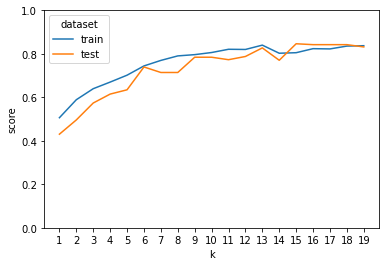

In [28]:
g = sns.lineplot(data=df_results, x="k", y="score", hue="dataset")
g.set_ylim([0,1])
g.set_xticks(list(range(1,20)))
g

In [29]:
df_results.pivot(columns="dataset", index="k", values="score").round(3)

dataset,test,train
k,,
1,0.431,0.506
2,0.496,0.589
3,0.574,0.640
4,0.615,0.670
5,0.635,0.702
6,0.740,0.744
7,0.714,0.770
8,0.714,0.791
9,0.784,0.796


## Checking dependence on choice of independent test set

Using 10 random numbers from random.org, we select other independent test sets, in order to compare the average performance to our analysis above. 

In [30]:
records = []
for random_seed in [7553, 4992, 2189, 4299, 2961, 4209, 4664, 9374, 8123, 443]:
    X, y, _, sample_names = preprocess_pandas(
        df_combined, labels, return_names=True
    )
    (
        X_train,
        X_test,
        y_train,
        y_test,
        sample_names_train,
        sample_names_test,
    ) = get_independent_test_set(X, y, sample_names=sample_names, test_size=0.2, random_state=random_seed)
    pipe = make_pipeline(
        FeatureCombinator(feature_names, feature_types), StandardScaler(), SVC()
    )

    gsearch = GridSearchCV(
        pipe,
        param_grid={
            "svc__class_weight": ["balanced"],
            "featurecombinator__feature_types": all_subsets
        },
        scoring="f1_macro",
        n_jobs=-1
    )

    gsearch.fit(X_train, y_train)
    test_score = f1_score(y_test, gsearch.best_estimator_.predict(X_test), average="macro")
    records.append([random_seed,"train", "f1_macro_mean", gsearch.best_score_])
    records.append([random_seed,"train", "selected_features", gsearch.best_params_["featurecombinator__feature_types"]])
    records.append([random_seed,"test", "f1_macro_mean", test_score])

df_records = pd.DataFrame.from_records(records, columns=["random_seed","dataset", "type", "value"])

The model shows considerable overfitting on the training set, as well as a high standard deviation of 0.14 among the test scores.

In [37]:
df_records[df_records.type != "selected_features"].drop("random_seed", axis=1).groupby(["type", "dataset"]).mean().round(3)

value
type          dataset       
f1_macro_mean test     0.961
              train    0.960

Standard deviations of the training and test scores are low:

In [41]:
df_records[(df_records.type=="f1_macro_mean")].drop(["random_seed", "type"], axis=1).groupby("dataset").std().round(3)

,value
dataset,
test,0.029
train,0.013


In [32]:
df_records[(df_records.dataset=="train")&(df_records.type=="f1_macro_mean")].value.std().round(5)

0.01309

The selected features vary widely among the training sets, the only consistency seems to be that PSSM_50_3 is selected in all cases.

<AxesSubplot:>

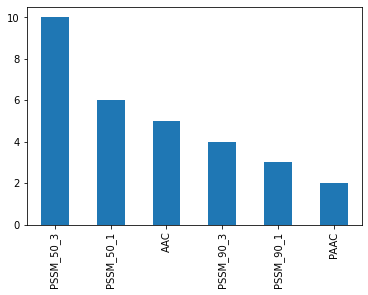

In [33]:
df_records[df_records.type == "selected_features"].value.explode().value_counts().plot.bar()

The only multi-feature that is selected more than once is the combination of AAC and PSSM_50_3. All of the multi-features are made up of two or more individual features.

In [34]:
df_records[df_records.type == "selected_features"].value.value_counts()

[AAC, PSSM_50_3]                                      2
[PSSM_50_3, PSSM_90_1, PSSM_90_3]                     1
[PSSM_50_3, PSSM_90_3]                                1
[PAAC, PSSM_50_1, PSSM_50_3]                          1
[AAC, PSSM_50_1, PSSM_50_3, PSSM_90_3]                1
[AAC, PSSM_50_1, PSSM_50_3, PSSM_90_1]                1
[PSSM_50_1, PSSM_50_3]                                1
[PAAC, PSSM_50_1, PSSM_50_3, PSSM_90_1, PSSM_90_3]    1
[AAC, PSSM_50_1, PSSM_50_3]                           1
Name: value, dtype: int64

## Only using individual features

Combining features based on training sets seems to cause overfitting. What if we only let the algorithm decide between the individual features, not combinations of them? 

In [35]:
pipe = make_pipeline(
    FeatureCombinator(feature_names, feature_types), StandardScaler(), SVC()
)

gsearch = GridSearchCV(
    pipe,
    param_grid={
        "svc__decision_function_shape": ["ovo", "ovr"],
        "svc__class_weight": ["balanced", None],
        "svc__C": [1, 0.1, 10, 100],
        "svc__gamma": ["scale", 0.01, 0.1, 1],
        "featurecombinator__feature_types": [["AAC"], ["PAAC"], ["PSSM_50_1"], ["PSSM_50_3"], ["PSSM_90_1"], ["PSSM_90_3"]]
    },
    scoring="f1_macro",
    n_jobs=-1
)

gsearch.fit(X_train, y_train)

print(gsearch.best_score_.round(3))
print(gsearch.best_params_)
test_score = f1_score(y_test, gsearch.best_estimator_.predict(X_test), average="macro")
print(test_score.round(3))

f1_score(y_test, gsearch.best_estimator_.predict(X_test), average="macro")

0.97
{'featurecombinator__feature_types': ['PSSM_50_3'], 'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__decision_function_shape': 'ovo', 'svc__gamma': 'scale'}
1.0


1.0

## Only using one combined feature

Another way to reduce overfitting could be limiting the model to only the most-selected combined feature: AAC+PSSM_50_3

In [36]:
pipe = make_pipeline(
    FeatureCombinator(feature_names, feature_types), StandardScaler(), SVC()
)

gsearch = GridSearchCV(
    pipe,
    param_grid={
        "svc__decision_function_shape": ["ovo", "ovr"],
        "svc__class_weight": ["balanced", None],
        "svc__C": [1, 0.1, 10, 100],
        "svc__gamma": ["scale", 0.01, 0.1, 1],
        "featurecombinator__feature_types": [["AAC", "PSSM_50_3"]]
    },
    scoring="f1_macro",
    n_jobs=-1
)

gsearch.fit(X_train, y_train)

print(gsearch.best_score_.round(3))
print(gsearch.best_params_)
test_score = f1_score(y_test, gsearch.best_estimator_.predict(X_test), average="macro")
print(test_score.round(3))

0.963
{'featurecombinator__feature_types': ['AAC', 'PSSM_50_3'], 'svc__C': 10, 'svc__class_weight': 'balanced', 'svc__decision_function_shape': 'ovo', 'svc__gamma': 'scale'}
1.0


## Conclusion

Our best machine learning feature for classifying A. Thaliana transporter in to three classes, the Multi-PSSM feature, achieved a mean F1 score of 0.971 on the training set, and 0.964 on the test set. 

When instead using the feature selector method implemented in this notebook, the training scores are very similar, but testing scores drop sharply. Selecting a combination of features based on the training set leads to a drastic increase in overfitting on the training set. 

This is also the case when using feature selection with ANOVA, and when only optimizing the feature choice and not the SVM hyperparamters.

Therefore, our conclusion is that one should use the multi-PSSM feature directly, instead of automatic feature selection presented here.